# Step 7: 2-D Linear Convection

The equation we are considering is written as $$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + c \frac{\partial u}{\partial y} = 0$$ where $c$ is a constant and $u = u\left(x, y, t\right)$.

In these notebooks, the implementation of the $\textbf{Finite Difference Method} \left(FEM\right)$ in 2-D is based on a 2-D uniform (rectangular) grid, where each point is identified by a pair of coordinates $\left(x_i = x_0 + i\Delta x,\; y_j = y_0 + j\Delta y\right)$. The discretized version of time and space derivatives are obtained in the same manner as done in the previous notebooks, obtaining as always a truncation error of the same order as the first power of $\Delta t$, $\Delta x$ and $\Delta y$.

The discretized version of the considered equation has only one unknown, which can be isolated $$u_{i,\; j}^{n+1} = u_{i,\; j}^n - c\frac{\Delta t}{\Delta x} \left(u_{i,\; j}^n - u_{i-1,\; j}^n\right) - c\frac{\Delta t}{\Delta y}\left(u_{i,\; j}^n - u_{i,\; j-1}^n\right)$$ using backward difference scheme for space derivates and forward difference scheme for the time one. The initial conditions are given as a 2-D hat function:

$$u\left(x, y, 0\right) = \left\{ \begin{array}{rcl} 2 & for & 0.5 \leq x,y \leq 1 \\ 1 & for & 0 \leq\; x,y < 0.5\; \wedge\; 1 < x,y \leq\; 2 \end{array}\right. \,$$ 

With boundaries conditions set as $u\left(x,\; y\right) = 1$ for $\left(x,\; y\right)$ on the contour (where $x = 0,\;2 \vee y = 0,\; 2$).

Noted issues:
- suffering from numerical diffusion, because the hat function spreades over time. It is linked with the definition of $dt$ based on the Courant number, which should stay below 0.5 (I don't know the theoretical reasons, I just tried different values...); for what I know, the definition of $dt$ is pretty informal so I'll stick with the suggestions given by prof. Barba and Dr. Gan. What I understood is that it's advisable and wiser if we define $dt$ based on the system's properties such as grid parameters (distances between points) and such as convection speed ($c$ or $u$ or $v$) or diffusivity (like $\nu$).
- unable to simulate when $c < 0$, that's because we discretized with a backward difference scheme. For negative convection velocity I should use a 2-D extension of the upwind scheme implemented for 1-D nonlinear convection equation.

References of used functions and modules in this notebook:
- matplotlib.cm: https://matplotlib.org/stable/api/cm_api.html
- basic 3-D plot with matplotlib: https://matplotlib.org/stable/gallery/mplot3d/surface3d_2.html#sphx-glr-gallery-mplot3d-surface3d-2-py
- video lesson 6: https://youtu.be/D9_L4-FG80k?si=9qODuuuLOxWbV2QC.

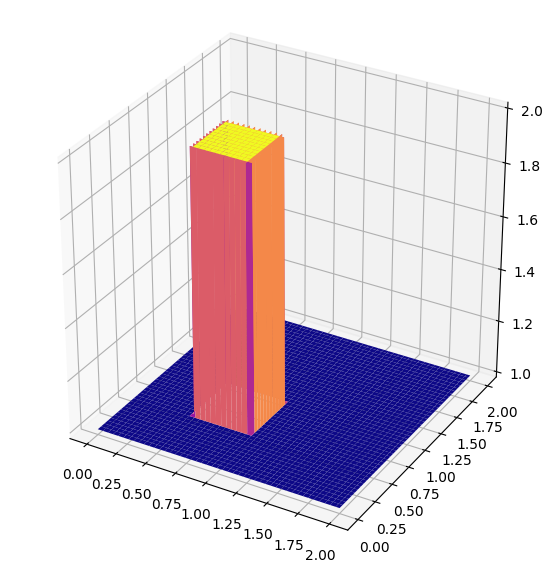

In [35]:
# Let's start importing some useful 3D packages
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import numpy as np
from matplotlib import pyplot as plt, cm

# Setting up the sim
nx = 321
ny = 321
nt = 300
c = 0.5

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = 0.5   # CFL number: default is 0.2 - For a sigma > 0.5, the code is unstable.
dt = sigma*dx / abs(c)   # Dr. Gan's dt is just dt = sigma*dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

ICs = np.ones((nx, ny))   # Initial conditions
ICs[int(0.5 / dx) : int(1 / dx + 1), int(0.5 / dy) : int(1 / dy + 1)] = 2

u = ICs.copy()
un = np.zeros((nx, ny))   # Placeholder of u during computation

# Plot of ICs
fig = plt.figure(figsize = (11, 7), dpi = 100)
X, Y = np.meshgrid(x, y)   # Matrix which holds mesh infos to pass to ax.plot_surface

ax = fig.add_subplot(111, projection = '3d')   # Dunno what it exactly does...
ax.set_aspect('equal')
ax.plot_surface(X, Y, ICs, cmap = cm.plasma)

plt.show()
# plt.close()

In [41]:
# %%timeit

# Nested for-loops (1.65 s):
'''
for n in range(0, nt + 1):
    un = u.copy()
    row, col = u.shape   # Which are equal to nx and ny
    for i in range(1, row):   # Loop from 1 to nx, because u[nx,j] can be computed
        for j in range(1, col):   # Loop with same logic as before
            u[i, j] = un[i, j] - c*(dt/dx)*(un[i,j] - un[i-1,j]) - c*(dt/dy)*(un[i,j] - un[i, j-1])
            
            # Boundary conditions:
            u[0,:] = 1
            u[-1,:] = 1
            u[:,0] = 1
            u[:,-1] = 1
'''

# Array operations (3.75 ms):

for n in range(0, nt + 1):
    un = u.copy()
    u[1:,1:] = un[1:,1:] - c*(dt/dx)*(un[1:,1:] - un[0:-1,1:]) - c*(dt/dy)*(un[1:,1:] - un[1:, 0:-1])
    
    # Boundary conditions:
    u[0,:] = 1
    u[-1,:] = 1
    u[:,0] = 1
    u[:,-1] = 1


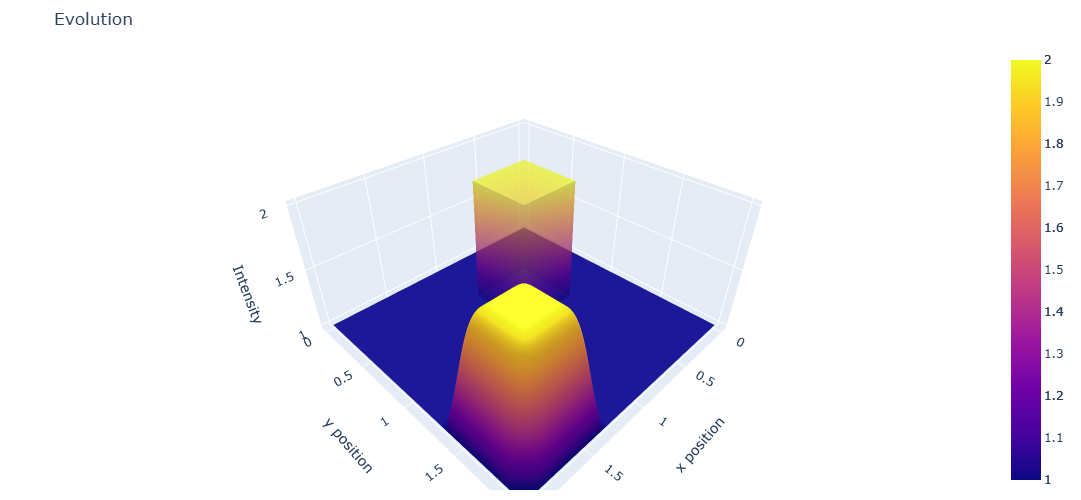

In [44]:
'''
# 3-D interactive visualization using matplotlib (pretty slow)

# %matplotlib widget   # Magic function: change the backend of matplotlib plots (equivalent to notebook)
fig = plt.figure(figsize = (11, 7), dpi = 100)
X, Y = np.meshgrid(x, y)   # Matrix which holds mesh infos to pass to ax.plot_surface

ax = fig.add_subplot(111, projection = '3d')   # Dunno what it exactly does...
ax.set_aspect('equal')
ax.plot_surface(X, Y, u, cmap = cm.viridis, label = 'Evolution')
ax.plot_surface(X, Y, ICs, cmap = cm.plasma, label = 'ICs', alpha = 0.3)

plt.show()
# %matplotlib inline
'''
# 3-D interactive visualization using plotly (way faster and smoother)

fig = go.Figure(data=[go.Surface(z=u, x=x, y=y, name='u'), 
                      go.Surface(z=ICs, x=x, y=y, name='ICs', opacity=0.5)])
# fig.add_scatter3d(x=desl_to_fit[:,2], y=desl_to_fit[:,1], z=desl_to_fit[:,0], mode='markers', marker = {'color' : 'green'})
fig.update_layout(title='Evolution', autosize=False, showlegend=False, 
                  width=900, height=500, 
                  margin=dict(l=65, r=50, b=10, t=50),
                  scene=dict(xaxis_title='x position', yaxis_title='y position', zaxis_title='Intensity'))

fig.show()
# '''